# ZA cohort validation

Imports

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from datetime import timedelta
from tqdm import tqdm
from coding_assets.python import xtra_viz

In [2]:
# declare paths

sa_inputdata_path = r"C:\Users\flori\OneDrive - univ-angers.fr\Documents\Home\Research\SPECTR\ISPECTR\data\proc\sa_is_full.csv"
sa_groundtruth_path = r"C:\Users\flori\OneDrive - univ-angers.fr\Documents\Home\Research\SPECTR\ISPECTR\data\cameron_may_2024\processed_IFE_reports.xlsx"
sa_x_data_path = r"C:\Users\flori\OneDrive - univ-angers.fr\Documents\Home\Research\SPECTR\ISPECTR\output\mednext_L_SA_preds\sa_x.npy"
sa_predictions_path = r"C:\Users\flori\OneDrive - univ-angers.fr\Documents\Home\Research\SPECTR\ISPECTR\output\mednext_L_SA_preds\sa_preds.npy"

Load data and preprocess

In [0]:
# load
sa_inputdata = pd.read_csv(sa_inputdata_path)
sa_groundtruth_dataframe = pd.read_excel(sa_groundtruth_path)
x_array = np.load(sa_x_data_path)
pred_array = np.load(sa_predictions_path)

# update dates to correct format
sa_inputdata.Ref_data_analisi = pd.to_datetime(sa_inputdata.Ref_data_analisi, unit='D', origin='1899-12-30')
sa_groundtruth_dataframe.ife_episode_date = pd.to_datetime(sa_groundtruth_dataframe.ife_episode_date, format="%d/%m/%Y %H:%M", errors="coerce")

# keep only ground truth annotations for which we have input data for, and sort accordingly
sa_inputdata.id_unique.isin(sa_groundtruth_dataframe.episode).value_counts()  # True for 699, False for 20
sa_groundtruth_dataframe.episode.isin(sa_inputdata.id_unique).value_counts()  # True for 699, False for 13776
# we have GT annotations for 699 samples; we are missing them for 20 samples
# let's check who those 20 are
sa_inputdata.id_unique[~sa_inputdata.id_unique.isin(sa_groundtruth_dataframe.episode)]
# they are indeed not found manually in the GT annotations file

sa_annotations = sa_inputdata[["Ref_data_analisi", "id_unique"]].merge(sa_groundtruth_dataframe, left_on="id_unique", right_on="episode", how="left")

In [30]:
len(sa_annotations)  # 679

679

In [0]:
# we don't have the sampling time in our data, only the date of analysis
# so we can at least check if this date of analysis is not too far from the sampling date annotated in our GT annotations data file
sa_annotations["delta_sampling_analysis"] = (sa_annotations.Ref_data_analisi - sa_annotations.ife_episode_date) / timedelta(days=1)
sa_annotations.delta_sampling_analysis.max()  # 10 days max
sa_annotations.delta_sampling_analysis.min()  # min is -0.5 days  # TODO this is inconsistent

# convert groundtruth df data to real classes like "IgG_kappa", etc.
# we will use the "ife_category.1" variable which is:

In [31]:
sa_annotations["ife_category.1"].value_counts()

ife_category.1
2.0    543
1.0     74
3.0     62
Name: count, dtype: int64

In [3]:
# N/A => no intel (discard sample)
# 1   => no monoclonal detected (negative)
# 2   => 1 monoclonal detected => look at 3 last columns to see which; could be full antibody, HC only or LC only
# 3   => 2+ monoclonals detected => same
# 4   => equivocal (discard, and keep for later)
# 5   => negative while previously positive, or very faint signal (discard, and keep for later)
# summary:
# look at ife_category.1 => if 1 or 4 or 5, discard, else keep and
# look at three last columns to get the class

# FILTER
# finally annotate which ones we can analyze
sa_annotations["result_available"] = sa_annotations["ife_category.1"].isin([1, 2, 3])
keep_filter_ = sa_annotations["result_available"].values
sa_annotations = sa_annotations[keep_filter_].copy()
x_array = x_array[keep_filter_]
pred_array = pred_array[keep_filter_]

Prepare variables, names, etc.

In [4]:
isotype_map_dict = {'igg-lambda': 0,
                    'igg-kappa': 1,
                    'iga-lambda': 2,
                    'iga-kappa': 3,
                    'igm-lambda': 4,
                    'igm-kappa': 5,
                    'igg': 6,
                    'iga': 7,
                    'igm': 8,
                    'kappa': 9,
                    'lambda': 10}

SIMPLE_CLASS_UNKNOWN = -1
SIMPLE_CLASS_NEGATIVE = 0
SIMPLE_CLASS_MONOCLONAL = 1
SIMPLE_CLASS_BICLONAL = 2

IG_FLAG_G = 2 ** 0  # 1
IG_FLAG_A = 2 ** 1  # 2
IG_FLAG_M = 2 ** 2  # 4
IG_FLAG_K = 2 ** 3  # 8
IG_FLAG_L = 2 ** 4  # 16

def ig_class_from_concat_str(concat_str):
    # variables that we will return
    simple_class = SIMPLE_CLASS_UNKNOWN
    # turn into a list of isotypes, e;g. "igg-lambda"
    isotypes_list = eval(concat_str)
    # convert this list of isotypes into numerical encoded isotypes; also helps checking all isotypes are known (i.e., expected values)
    isotypes_list = [isotype_map_dict[e] for e in isotypes_list]
    # turn into classes that we will be able to interpret
    number_unique_isotypes = len(np.unique(isotypes_list))
    if number_unique_isotypes == 0:
        simple_class = SIMPLE_CLASS_NEGATIVE
    elif number_unique_isotypes == 1:
        simple_class = SIMPLE_CLASS_MONOCLONAL
    else:
        simple_class = SIMPLE_CLASS_BICLONAL
    return simple_class


def ig_str_to_flag(ig_str):
    import re
    if re.match("^ig[gam]-(kappa|lambda)$", ig_str) is not None:
        heavy_ = {"g": IG_FLAG_G, "a": IG_FLAG_A, "m": IG_FLAG_M}[ig_str[2]]
        if len(ig_str) == 9:
            return heavy_ | IG_FLAG_K
        else:
            return heavy_ | IG_FLAG_L
    if re.match("^ig[gam]$", ig_str) is not None:
        heavy_ = {"g": IG_FLAG_G, "a": IG_FLAG_A, "m": IG_FLAG_M}[ig_str[2]]
        return heavy_
    if ig_str == "kappa":
        return IG_FLAG_K
    if ig_str == "lambda":
        return IG_FLAG_L
    raise Exception(f"unknown {ig_str=}")


def ig_flag_from_concat_str(concat_str):
    # variables that we will return
    simple_class = SIMPLE_CLASS_UNKNOWN
    # turn into a list of isotypes, e;g. "igg-lambda"
    isotypes_list = eval(concat_str)
    # convert this list of isotypes into numerical encoded isotypes; also helps checking all isotypes are known (i.e., expected values)
    isotypes_flags = [ig_str_to_flag(e) for e in isotypes_list]
    result_flag = 0
    for flag in isotypes_flags:
        result_flag |= flag
    return result_flag


def iso_n_to_text(iso_n):
    if iso_n < 3:
        return "Ig" + "GAM"[iso_n]
    if iso_n == 3:
        return "Kappa"
    if iso_n == 4:
        return "Lambda"
    return "Unknown"

In [0]:
# prepare raw annotations
sa_annotations["concat_chains"] = (sa_annotations["Heavy-Light Chain Pairs"] + sa_annotations["Unpaired Heavy Chains"] + sa_annotations["Unpaired Light Chains"]).str.replace("][", ",").str.replace(",,", ",").str.replace(",]", "]").str.replace("[,", "[")
sa_annotations.loc[sa_annotations["concat_chains"].isna(), "concat_chains"] = "[]"
# create 'simple' annotations
sa_annotations["simple_annot_class"] = sa_annotations["concat_chains"].map(ig_class_from_concat_str)
# create 'flag' annotations (detailed)
sa_annotations["flag_class"] = sa_annotations["concat_chains"].map(ig_flag_from_concat_str)
# convert flag back to classes
sa_annotations["annot_g"] = ((sa_annotations["flag_class"] | IG_FLAG_G) == sa_annotations["flag_class"]) * 1
sa_annotations["annot_a"] = ((sa_annotations["flag_class"] | IG_FLAG_A) == sa_annotations["flag_class"]) * 1
sa_annotations["annot_m"] = ((sa_annotations["flag_class"] | IG_FLAG_M) == sa_annotations["flag_class"]) * 1
sa_annotations["annot_k"] = ((sa_annotations["flag_class"] | IG_FLAG_K) == sa_annotations["flag_class"]) * 1
sa_annotations["annot_l"] = ((sa_annotations["flag_class"] | IG_FLAG_L) == sa_annotations["flag_class"]) * 1

In [32]:
sa_annotations["simple_annot_class"].value_counts()

simple_annot_class
1    543
0     74
2     62
Name: count, dtype: int64

In [34]:
sa_annotations["flag_class"].value_counts()

flag_class
9     264
17    146
0      74
10     45
18     33
12     27
25     26
16     14
20      8
8       8
29      7
27      6
11      4
21      3
28      3
23      2
2       2
1       2
31      1
13      1
26      1
24      1
30      1
Name: count, dtype: int64

In [36]:
sa_annotations["annot_g"].value_counts()

annot_g
1    462
0    217
Name: count, dtype: int64

In [37]:
sa_annotations["annot_a"].value_counts()

annot_a
0    584
1     95
Name: count, dtype: int64

In [38]:
sa_annotations["annot_m"].value_counts()

annot_m
0    626
1     53
Name: count, dtype: int64

In [39]:
sa_annotations["annot_k"].value_counts()

annot_k
1    395
0    284
Name: count, dtype: int64

In [40]:
sa_annotations["annot_l"].value_counts()

annot_l
0    427
1    252
Name: count, dtype: int64

In [5]:
# convert ground truth to arrays
gt_isotype_class = sa_annotations[[f"annot_{iso}" for iso in "gamkl"]].values
gt_any_class = (gt_isotype_class.max(axis=1) >= 0.5) * 1

# really simple for now => just see if an abnormality was detected in parallel in igg, iga, igm, kappa, and lambda
# then
pred_isotype_score = pred_array.max(axis=2)
pred_any_score = pred_isotype_score.max(axis=1)
pred_isotype_binary = (pred_isotype_score.astype(float) >= 0.5) * 1
pred_any_binary = (pred_any_score >= 0.5) * 1

# detection by isotype:

In [6]:
ci_level = .95

C:\Users\flori\OneDrive - univ-angers.fr\Documents\Home\Research\Common\coding_assets\python\xtra_viz.py:358: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)
C:\Users\flori\OneDrive - univ-angers.fr\Documents\Home\Research\Common\coding_assets\python\xtra_viz.py:359: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticks, fontdict=ticks_font_params)
C:\Users\flori\OneDrive - univ-angers.fr\Documents\Home\Research\Common\coding_assets\python\xtra_viz.py:358: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticks, fontdict=ticks_font_params)
C:\Users\flori\OneDrive - univ-angers.fr\Documents\Home\Research\Common\coding_assets\python\xtra_viz.py:359: UserW

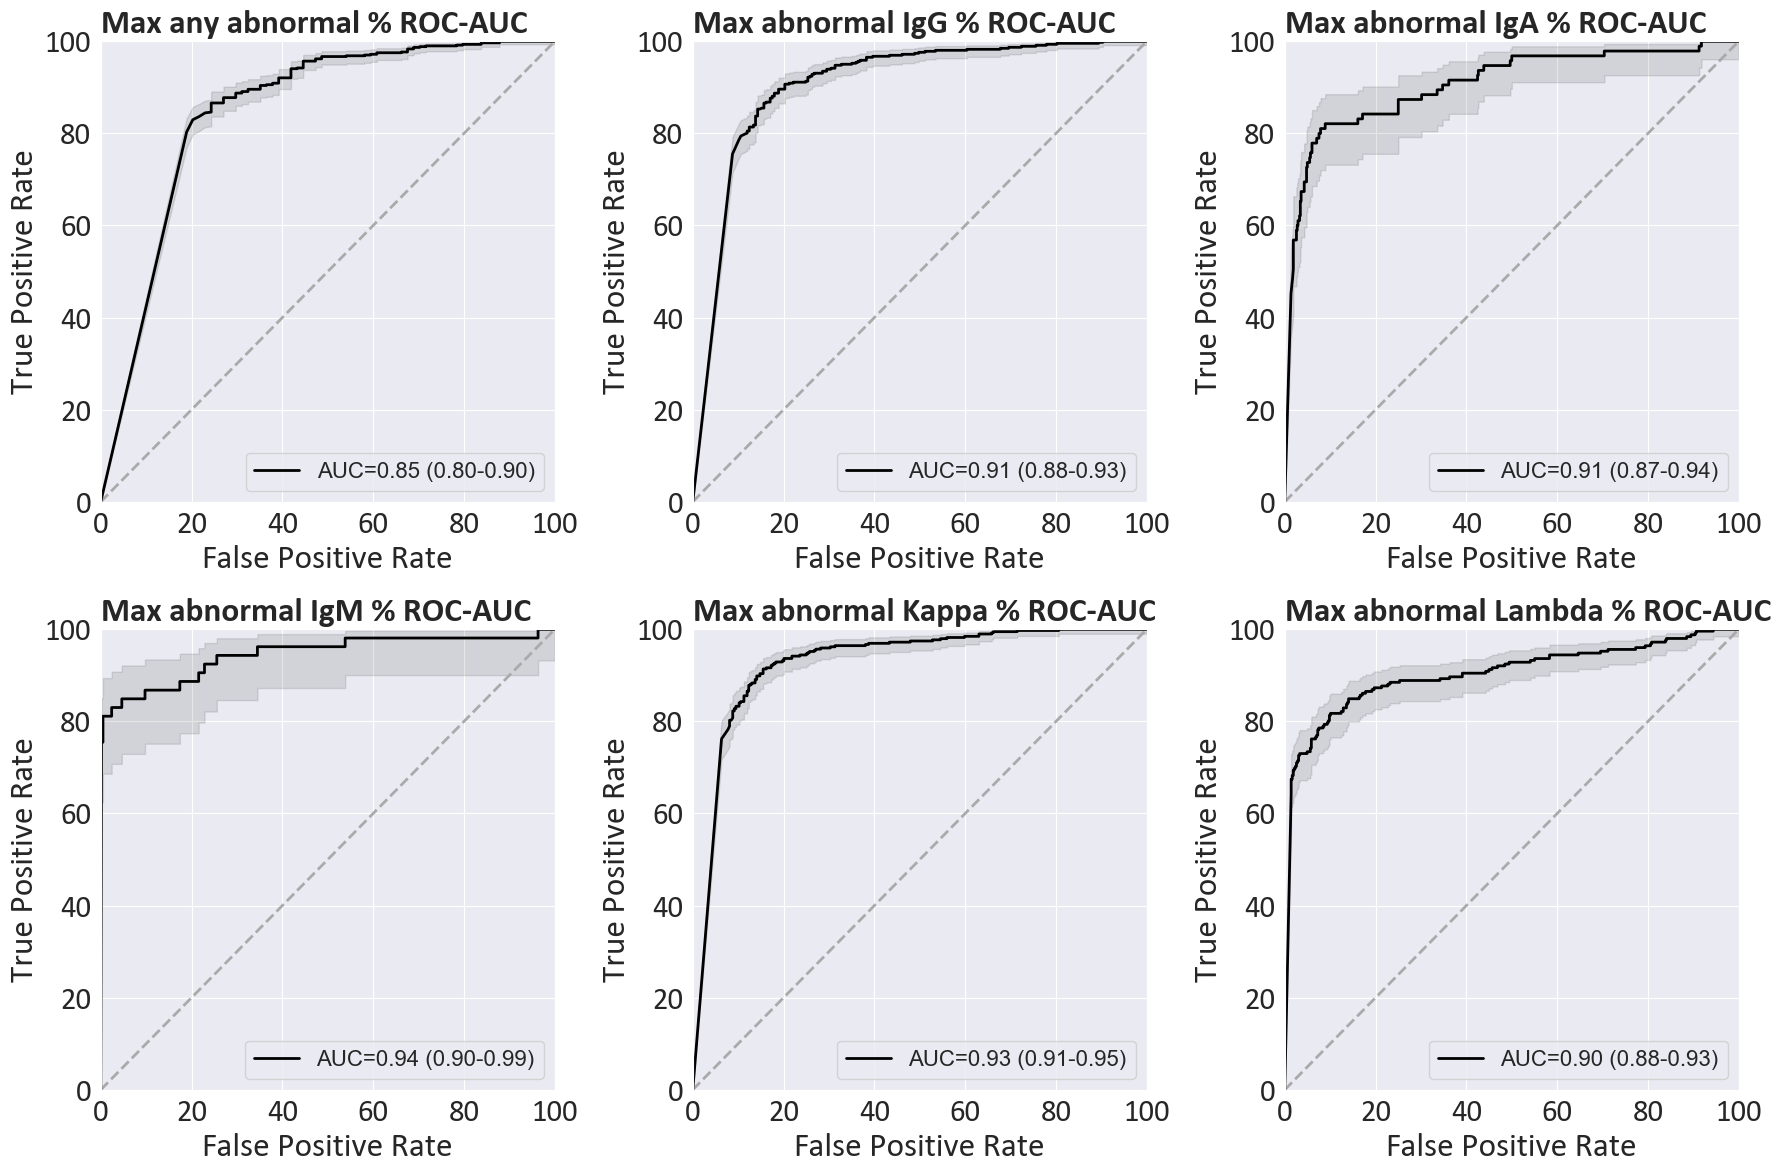

In [7]:
plt.figure(figsize=(xtra_viz.pp_size * 3, xtra_viz.pp_size * 2))
plt.subplot(2, 3, 1)
xtra_viz.plot_roc(y=gt_any_class, y_=pred_any_score,
                  confidence_level=ci_level, suptitle=f"Max any abnormal % ROC-AUC")
for iso_n in range(5):
    plt.subplot(2, 3, iso_n + 2)
    xtra_viz.plot_roc(y=gt_isotype_class[:, iso_n], y_=pred_isotype_score[:, iso_n],
                      confidence_level=ci_level, suptitle=f"Max abnormal {iso_n_to_text(iso_n)} % ROC-AUC")
plt.tight_layout()
plt.show()

In [8]:
# detect by biclonal/negative/monoclonal
class_pred_df = pd.crosstab(pd.Series(sa_annotations.simple_annot_class.values, name="Ground truth").map({1: "Monoclonal", 2: "Biclonal", 0: "Negative"}),
                            pd.Series(pred_any_binary, name="Predicted").map({1: "Positive", 0: "Negative"}))
class_pred_df
# Predicted     Negative  Positive
# Ground truth
# Biclonal             4        58
# Monoclonal          35       508
# Negative            43        31
100 * class_pred_df / np.stack([class_pred_df.sum(axis=1).values, class_pred_df.sum(axis=1).values], axis=1)
# Predicted      Negative   Positive
# Ground truth
# Biclonal       6.451613  93.548387
# Monoclonal     6.445672  93.554328
# Negative      58.108108  41.891892

# TODO convert post-processed prediction maps to classif ("IgG_kappa", etc.)
index = 0
# positive_threshold = .5
# convert to maps
# pred_flags = ((pred_array > positive_threshold) * np.array([2**0, 2**1, 2**2, 2**3, 2**4])[None, :, None]).sum(axis=1)
# interpret maps

## Convert post-processed prediction maps to classif ("IgG_kappa", etc.)

In [9]:
TYPE_FLAG_TO_STR_DICT = {1: "IgG", 2: "IgA", 4: "IgM", 8: "Kappa", 16: "Lambda",
                         9: "IgG_Kappa", 17: "IgG_Lambda",
                         10: "IgA_Kappa", 18: "IgA_Lambda",
                         12: "IgM_Kappa", 20: "IgM_Lambda"}


def read_predmap(sample_preds, POSITIVE_THRESHOLD=.5, MIN_DETECTION_CONFIDENCE=.5, MIN_CLASS_CONFIDENCE=.0, MIN_PEAK_SIZE=3,
                 EXPECTED_TYPES=(1, 2, 4, 8, 16, 1+8, 1+16, 2+8, 2+16, 4+8, 4+16)):
    abn_flag = 0
    output_class = "Negative"
    metadata = {"sizes": [], "types": [], "starts": [], "ends": []}
    # convert to binary/class maps
    b_heatmap = sample_preds.max(axis=0)
    c_predmap = ((sample_preds >= POSITIVE_THRESHOLD) * np.array([2 ** 0, 2 ** 1, 2 ** 2, 2 ** 3, 2 ** 4])[:, None]).sum(axis=0)
    b_predmap = (c_predmap > 0) * 1
    # check start and end are at zero, else something weird is happening
    assert b_predmap[0] == 0
    assert b_predmap[-1] == 0
    # find locators (0 vs any abnormality)
    diffmap = np.diff(b_predmap)
    abn_area_start_locators = np.where(diffmap == 1)[0] + 1
    abn_area_end_locators = np.where(diffmap == -1)[0] + 1
    assert len(abn_area_start_locators) == len(abn_area_end_locators)
    # calculate area of each map
    abn_area_sizes = abn_area_end_locators - abn_area_start_locators
    # determine value of each abnormal area (e.g. what is detected there)
    abn_area_types = []
    abn_area_type_confidence = []
    abn_area_detection_confidence = []
    if len(abn_area_sizes) > 0:
        # as soon as something is detected, set the abnormal flag to 1 (even if those abnormalities are removed afterwards)
        abn_flag = 1
        # for each area, determine type and confidence (i.e. % of points agreeing with this type)
        for area_i in np.arange(len(abn_area_sizes)):
            type_points = c_predmap[abn_area_start_locators[area_i]:abn_area_end_locators[area_i]]
            preferred_type = np.median(type_points)
            type_confidence = (type_points == preferred_type).sum() / len(type_points)
            detection_confidence = np.mean(b_heatmap[abn_area_start_locators[area_i]:abn_area_end_locators[area_i]])
            abn_area_types.append(preferred_type)
            abn_area_type_confidence.append(type_confidence)
            abn_area_detection_confidence.append(detection_confidence)
        # merge
        abn_area_types = np.array(abn_area_types).astype(int)
        abn_area_type_confidence = np.array(abn_area_type_confidence)
        abn_area_detection_confidence = np.array(abn_area_detection_confidence)
        # post-process detected abnormal areas
        keep_abn_area_filter = np.array([True, ] * len(abn_area_sizes))
        # filter out if too small
        keep_abn_area_filter = np.logical_and(keep_abn_area_filter, abn_area_sizes >= MIN_PEAK_SIZE)
        # filter out if classification confidence too small
        keep_abn_area_filter = np.logical_and(keep_abn_area_filter, abn_area_type_confidence >= MIN_CLASS_CONFIDENCE)
        # filter out if detection confidence too small
        keep_abn_area_filter = np.logical_and(keep_abn_area_filter, abn_area_detection_confidence >= MIN_DETECTION_CONFIDENCE)
        # filter out unexpected types
        keep_abn_area_filter = np.logical_and(keep_abn_area_filter, np.isin(abn_area_types, EXPECTED_TYPES))
        # filter out effectively and convert
        abn_area_types_filtered = abn_area_types[keep_abn_area_filter]
        if len(abn_area_types_filtered) > 0:
            if len(np.unique(abn_area_types_filtered)) > 1:
                output_class = "Biclonal"
            else:
                output_class = TYPE_FLAG_TO_STR_DICT[abn_area_types_filtered[0]]
        # fill metadata for graphs later
        metadata["types"] = abn_area_types[keep_abn_area_filter]
        metadata["starts"] = abn_area_start_locators[keep_abn_area_filter]
        metadata["ends"] = abn_area_end_locators[keep_abn_area_filter]
        metadata["sizes"] = abn_area_sizes[keep_abn_area_filter]
    for key in ("types", "starts", "ends", "sizes"):
        metadata[key] = np.array(metadata[key])
    return output_class, abn_flag, metadata

In [10]:
pred_classes, pred_flags, pred_metadata = [], [], []
for index in tqdm(range(len(pred_array))):
    pred_class, pred_flag, pred_mt = read_predmap(sample_preds=pred_array[index, ...])
    pred_classes.append(pred_class)
    pred_flags.append(pred_flag)
    pred_metadata.append(pred_mt)

100%|██████████| 679/679 [00:00<00:00, 12505.30it/s]


Create tables

In [11]:
pred_classes_series = pd.Series(pred_classes, name="Predicted")
grountruth_classes_series = pd.Series(sa_annotations.flag_class.map({0: "Negative", **TYPE_FLAG_TO_STR_DICT}).values, name="Labeled")
grountruth_classes_series[grountruth_classes_series.isna()] = "Biclonal"
classes_crosstab = pd.crosstab(grountruth_classes_series, pred_classes_series)
final_columns_order = ['IgG', 'IgG_Kappa', 'IgG_Lambda',
                       'IgA', 'IgA_Kappa', 'IgA_Lambda',
                       'IgM', 'IgM_Kappa', 'IgM_Lambda',
                       'Kappa', 'Lambda', 'Biclonal', 'Negative']
classes_crosstab = classes_crosstab[[c for c in final_columns_order if c in classes_crosstab.columns]]
classes_crosstab = classes_crosstab.iloc[[np.where(classes_crosstab.index == c)[0][0] for c in final_columns_order if c in classes_crosstab.index], :]
classes_crosstab = pd.concat([classes_crosstab, classes_crosstab.sum(axis=1).rename("Total")], axis=1)

In [12]:
classes_crosstab

,IgG,IgG_Kappa,IgG_Lambda,IgA_Kappa,IgA_Lambda,IgM_Kappa,IgM_Lambda,Kappa,Lambda,Biclonal,Negative,Total
Labeled,,,,,,,,,,,,
IgG,0,1,0,0,0,0,0,0,0,0,1,2
IgG_Kappa,0,228,3,6,2,0,1,0,0,8,16,264
IgG_Lambda,0,7,124,0,1,1,0,0,0,1,12,146
IgA,0,0,0,0,1,0,0,0,0,0,1,2
IgA_Kappa,0,1,0,32,1,1,1,1,0,2,6,45
IgA_Lambda,0,0,0,0,22,1,0,0,0,1,9,33
IgM_Kappa,0,0,0,0,0,27,0,0,0,0,0,27
IgM_Lambda,0,0,0,0,0,0,6,0,1,1,0,8
Kappa,0,4,1,0,0,1,0,0,0,2,0,8


Let's merge all IgGs/As/Ms together, independently from the light chain

In [13]:
def remap_classes_func(str):
    if str in ("Negative", "Biclonal"):
        return str
    if str[:2] == "Ig":
        return str[:3]
    return "LC"
classes_crosstab_simple = pd.crosstab(grountruth_classes_series.map(remap_classes_func), pred_classes_series.map(remap_classes_func))
final_columns_order_simple = ['IgG', 'IgA', 'IgM', 'LC', 'Biclonal', 'Negative']
classes_crosstab_simple = classes_crosstab_simple[[c for c in final_columns_order_simple if c in classes_crosstab_simple.columns]]
classes_crosstab_simple = classes_crosstab_simple.iloc[[np.where(classes_crosstab_simple.index == c)[0][0] for c in final_columns_order_simple if c in classes_crosstab_simple.index], :]
classes_crosstab_simple = pd.concat([classes_crosstab_simple, classes_crosstab_simple.sum(axis=1).rename("Total")], axis=1)

In [14]:
classes_crosstab_simple

,IgG,IgA,IgM,LC,Biclonal,Negative,Total
Labeled,,,,,,,
IgG,363,9,2,0,9,29,412
IgA,1,56,3,1,3,16,80
IgM,0,0,33,1,1,0,35
LC,10,5,1,0,3,3,22
Biclonal,29,3,7,0,12,5,56
Negative,24,3,2,0,0,45,74


Also display in percentage

In [15]:
classes_crosstab_pct = (100 * classes_crosstab / classes_crosstab["Total"].values[:, None]).round(1)
classes_crosstab_pct_simple = (100 * classes_crosstab_simple / classes_crosstab_simple["Total"].values[:, None]).round(1)

In [16]:
classes_crosstab_pct

,IgG,IgG_Kappa,IgG_Lambda,IgA_Kappa,IgA_Lambda,IgM_Kappa,IgM_Lambda,Kappa,Lambda,Biclonal,Negative,Total
Labeled,,,,,,,,,,,,
IgG,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.0,100.0
IgG_Kappa,0.0,86.4,1.1,2.3,0.8,0.0,0.4,0.0,0.0,3.0,6.1,100.0
IgG_Lambda,0.0,4.8,84.9,0.0,0.7,0.7,0.0,0.0,0.0,0.7,8.2,100.0
IgA,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,50.0,100.0
IgA_Kappa,0.0,2.2,0.0,71.1,2.2,2.2,2.2,2.2,0.0,4.4,13.3,100.0
IgA_Lambda,0.0,0.0,0.0,0.0,66.7,3.0,0.0,0.0,0.0,3.0,27.3,100.0
IgM_Kappa,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,100.0
IgM_Lambda,0.0,0.0,0.0,0.0,0.0,0.0,75.0,0.0,12.5,12.5,0.0,100.0
Kappa,0.0,50.0,12.5,0.0,0.0,12.5,0.0,0.0,0.0,25.0,0.0,100.0


In [17]:
classes_crosstab_pct_simple

,IgG,IgA,IgM,LC,Biclonal,Negative,Total
Labeled,,,,,,,
IgG,88.1,2.2,0.5,0.0,2.2,7.0,100.0
IgA,1.2,70.0,3.8,1.2,3.8,20.0,100.0
IgM,0.0,0.0,94.3,2.9,2.9,0.0,100.0
LC,45.5,22.7,4.5,0.0,13.6,13.6,100.0
Biclonal,51.8,5.4,12.5,0.0,21.4,8.9,100.0
Negative,32.4,4.1,2.7,0.0,0.0,60.8,100.0


Finally display "pretty" tables with raw n + percentages

In [18]:
classes_crosstab.astype(str) + " (" + classes_crosstab_pct.astype(str) + "%)"

,IgG,IgG_Kappa,IgG_Lambda,IgA_Kappa,IgA_Lambda,IgM_Kappa,IgM_Lambda,Kappa,Lambda,Biclonal,Negative,Total
Labeled,,,,,,,,,,,,
IgG,0 (0.0%),1 (50.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (50.0%),2 (100.0%)
IgG_Kappa,0 (0.0%),228 (86.4%),3 (1.1%),6 (2.3%),2 (0.8%),0 (0.0%),1 (0.4%),0 (0.0%),0 (0.0%),8 (3.0%),16 (6.1%),264 (100.0%)
IgG_Lambda,0 (0.0%),7 (4.8%),124 (84.9%),0 (0.0%),1 (0.7%),1 (0.7%),0 (0.0%),0 (0.0%),0 (0.0%),1 (0.7%),12 (8.2%),146 (100.0%)
IgA,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (50.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (50.0%),2 (100.0%)
IgA_Kappa,0 (0.0%),1 (2.2%),0 (0.0%),32 (71.1%),1 (2.2%),1 (2.2%),1 (2.2%),1 (2.2%),0 (0.0%),2 (4.4%),6 (13.3%),45 (100.0%)
IgA_Lambda,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),22 (66.7%),1 (3.0%),0 (0.0%),0 (0.0%),0 (0.0%),1 (3.0%),9 (27.3%),33 (100.0%)
IgM_Kappa,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),27 (100.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),27 (100.0%)
IgM_Lambda,0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),0 (0.0%),6 (75.0%),0 (0.0%),1 (12.5%),1 (12.5%),0 (0.0%),8 (100.0%)
Kappa,0 (0.0%),4 (50.0%),1 (12.5%),0 (0.0%),0 (0.0%),1 (12.5%),0 (0.0%),0 (0.0%),0 (0.0%),2 (25.0%),0 (0.0%),8 (100.0%)


In [19]:
classes_crosstab_simple.astype(str) + " (" + classes_crosstab_pct_simple.astype(str) + "%)"

,IgG,IgA,IgM,LC,Biclonal,Negative,Total
Labeled,,,,,,,
IgG,363 (88.1%),9 (2.2%),2 (0.5%),0 (0.0%),9 (2.2%),29 (7.0%),412 (100.0%)
IgA,1 (1.2%),56 (70.0%),3 (3.8%),1 (1.2%),3 (3.8%),16 (20.0%),80 (100.0%)
IgM,0 (0.0%),0 (0.0%),33 (94.3%),1 (2.9%),1 (2.9%),0 (0.0%),35 (100.0%)
LC,10 (45.5%),5 (22.7%),1 (4.5%),0 (0.0%),3 (13.6%),3 (13.6%),22 (100.0%)
Biclonal,29 (51.8%),3 (5.4%),7 (12.5%),0 (0.0%),12 (21.4%),5 (8.9%),56 (100.0%)
Negative,24 (32.4%),3 (4.1%),2 (2.7%),0 (0.0%),0 (0.0%),45 (60.8%),74 (100.0%)


Look at some examples of samples that were not predicted the correct class

In [20]:
np.where(grountruth_classes_series.values != pred_classes_series.values)[0]

array([  0,  20,  22,  24,  25,  28,  32,  34,  37,  39,  40,  41,  45,
        47,  51,  53,  57,  58,  65,  78,  79,  82,  89,  93,  96,  97,
       103, 109, 114, 119, 120, 123, 129, 132, 135, 138, 144, 145, 147,
       152, 153, 154, 158, 160, 161, 167, 174, 177, 180, 183, 186, 187,
       188, 190, 192, 196, 197, 205, 208, 210, 211, 213, 214, 217, 221,
       226, 238, 240, 247, 249, 252, 255, 261, 266, 268, 274, 282, 283,
       286, 288, 289, 290, 291, 299, 300, 301, 306, 308, 309, 311, 328,
       329, 340, 341, 353, 355, 358, 359, 365, 367, 371, 373, 374, 375,
       383, 389, 391, 395, 397, 400, 406, 409, 419, 421, 422, 423, 430,
       433, 434, 436, 437, 441, 449, 450, 456, 458, 468, 474, 482, 485,
       492, 493, 496, 505, 513, 516, 518, 525, 533, 534, 535, 536, 537,
       539, 541, 542, 546, 548, 549, 560, 562, 573, 581, 586, 587, 589,
       592, 593, 594, 597, 601, 603, 604, 605, 616, 617, 627, 632, 635,
       636, 637, 644, 648, 650, 651, 657, 658, 660, 661, 662, 66

Function to display a sample's traces and predictions

In [21]:
# a function for plotting
def plot_it(idx, sample_x, sample_pred, gt_text, pred_text, pred_meta, debug):
    from coding_assets.python import xtra_viz
    plt.figure(figsize=(xtra_viz.pp_size * 3, xtra_viz.pp_size * 3))
    for num, lab in enumerate(['Ref', 'IgG', 'IgA', 'IgM', 'Kappa', 'Lambda']):
        num_pred = num - 1
        trace_label = lab + " trace"
        plt.subplot(6, 1, num + 1)
        if num_pred >= 0:
            tmp_df = pd.DataFrame({"x": np.concatenate([np.arange(len(sample_x)), np.arange(sample_pred.shape[1])]),
                                   lab: np.concatenate([sample_x[:, num], sample_pred[num_pred, :]]),
                                   trace_label: np.concatenate([["Input", ] * len(sample_x), ["Predicted", ] * sample_pred.shape[1]])})
        else:
            tmp_df = pd.DataFrame({"x": np.arange(len(sample_x)),
                                   lab: sample_x[:, num],
                                   trace_label: np.array(["Input", ] * len(sample_x))})
        sns.lineplot(data=tmp_df, x="x", y=lab, hue=trace_label)
        if num_pred >= 0:
            for p_type, p_start, p_end in zip(pred_meta["types"], pred_meta["starts"], pred_meta["ends"]):
                if ((p_type | (2 ** num_pred)) == p_type):
                    plt.fill_between(x=np.arange(p_start, p_end+1),
                                     y1=[0, ] * (p_end - p_start + 1),
                                     y2=sample_x[p_start:(p_end+1), num],
                                     color="red")
        if num == 0:
            plt.title(f'Trace {idx=}, labeled: {gt_text}, predicted: {pred_text}')

    plt.tight_layout()
    if debug != "inline":
        plt.savefig(os.path.join(debug, f"pred_plot_{idx=}.png"))
        plt.close()
    else:
        plt.show()

In [22]:
def plot_it_short(index):
    plot_it(idx=index, sample_x=x_array[index, ...], sample_pred=pred_array[index, ...],
            gt_text=grountruth_classes_series.iloc[index], pred_text=pred_classes_series.iloc[index],
            pred_meta=pred_metadata[index], debug="inline")

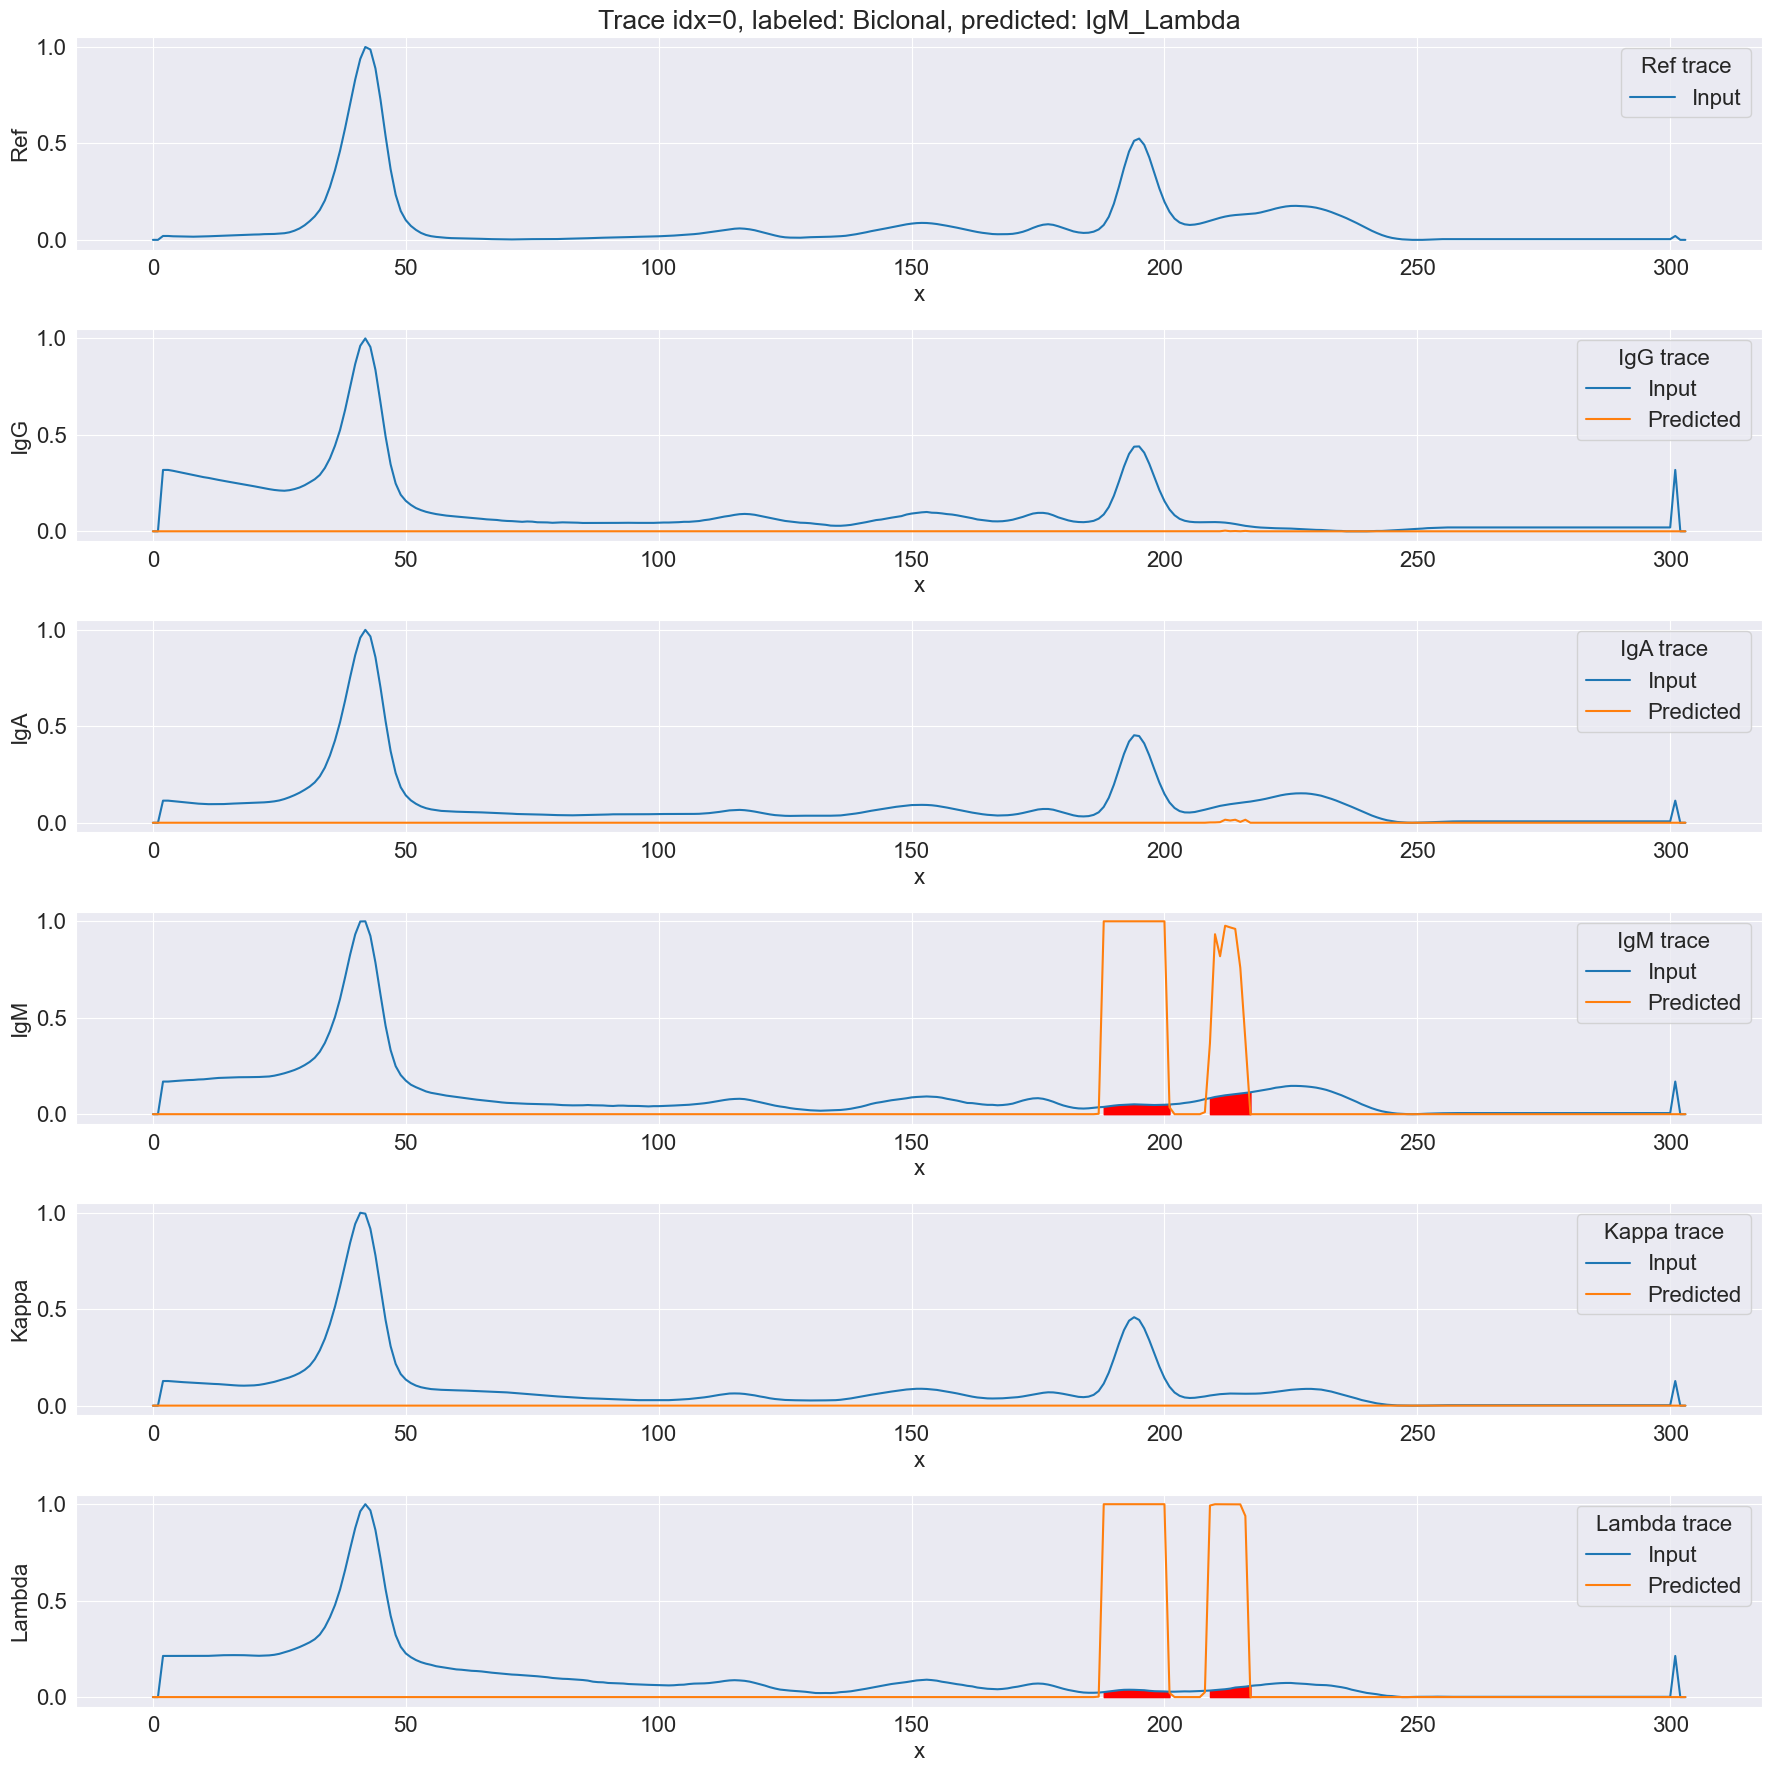

In [23]:
plot_it_short(0)

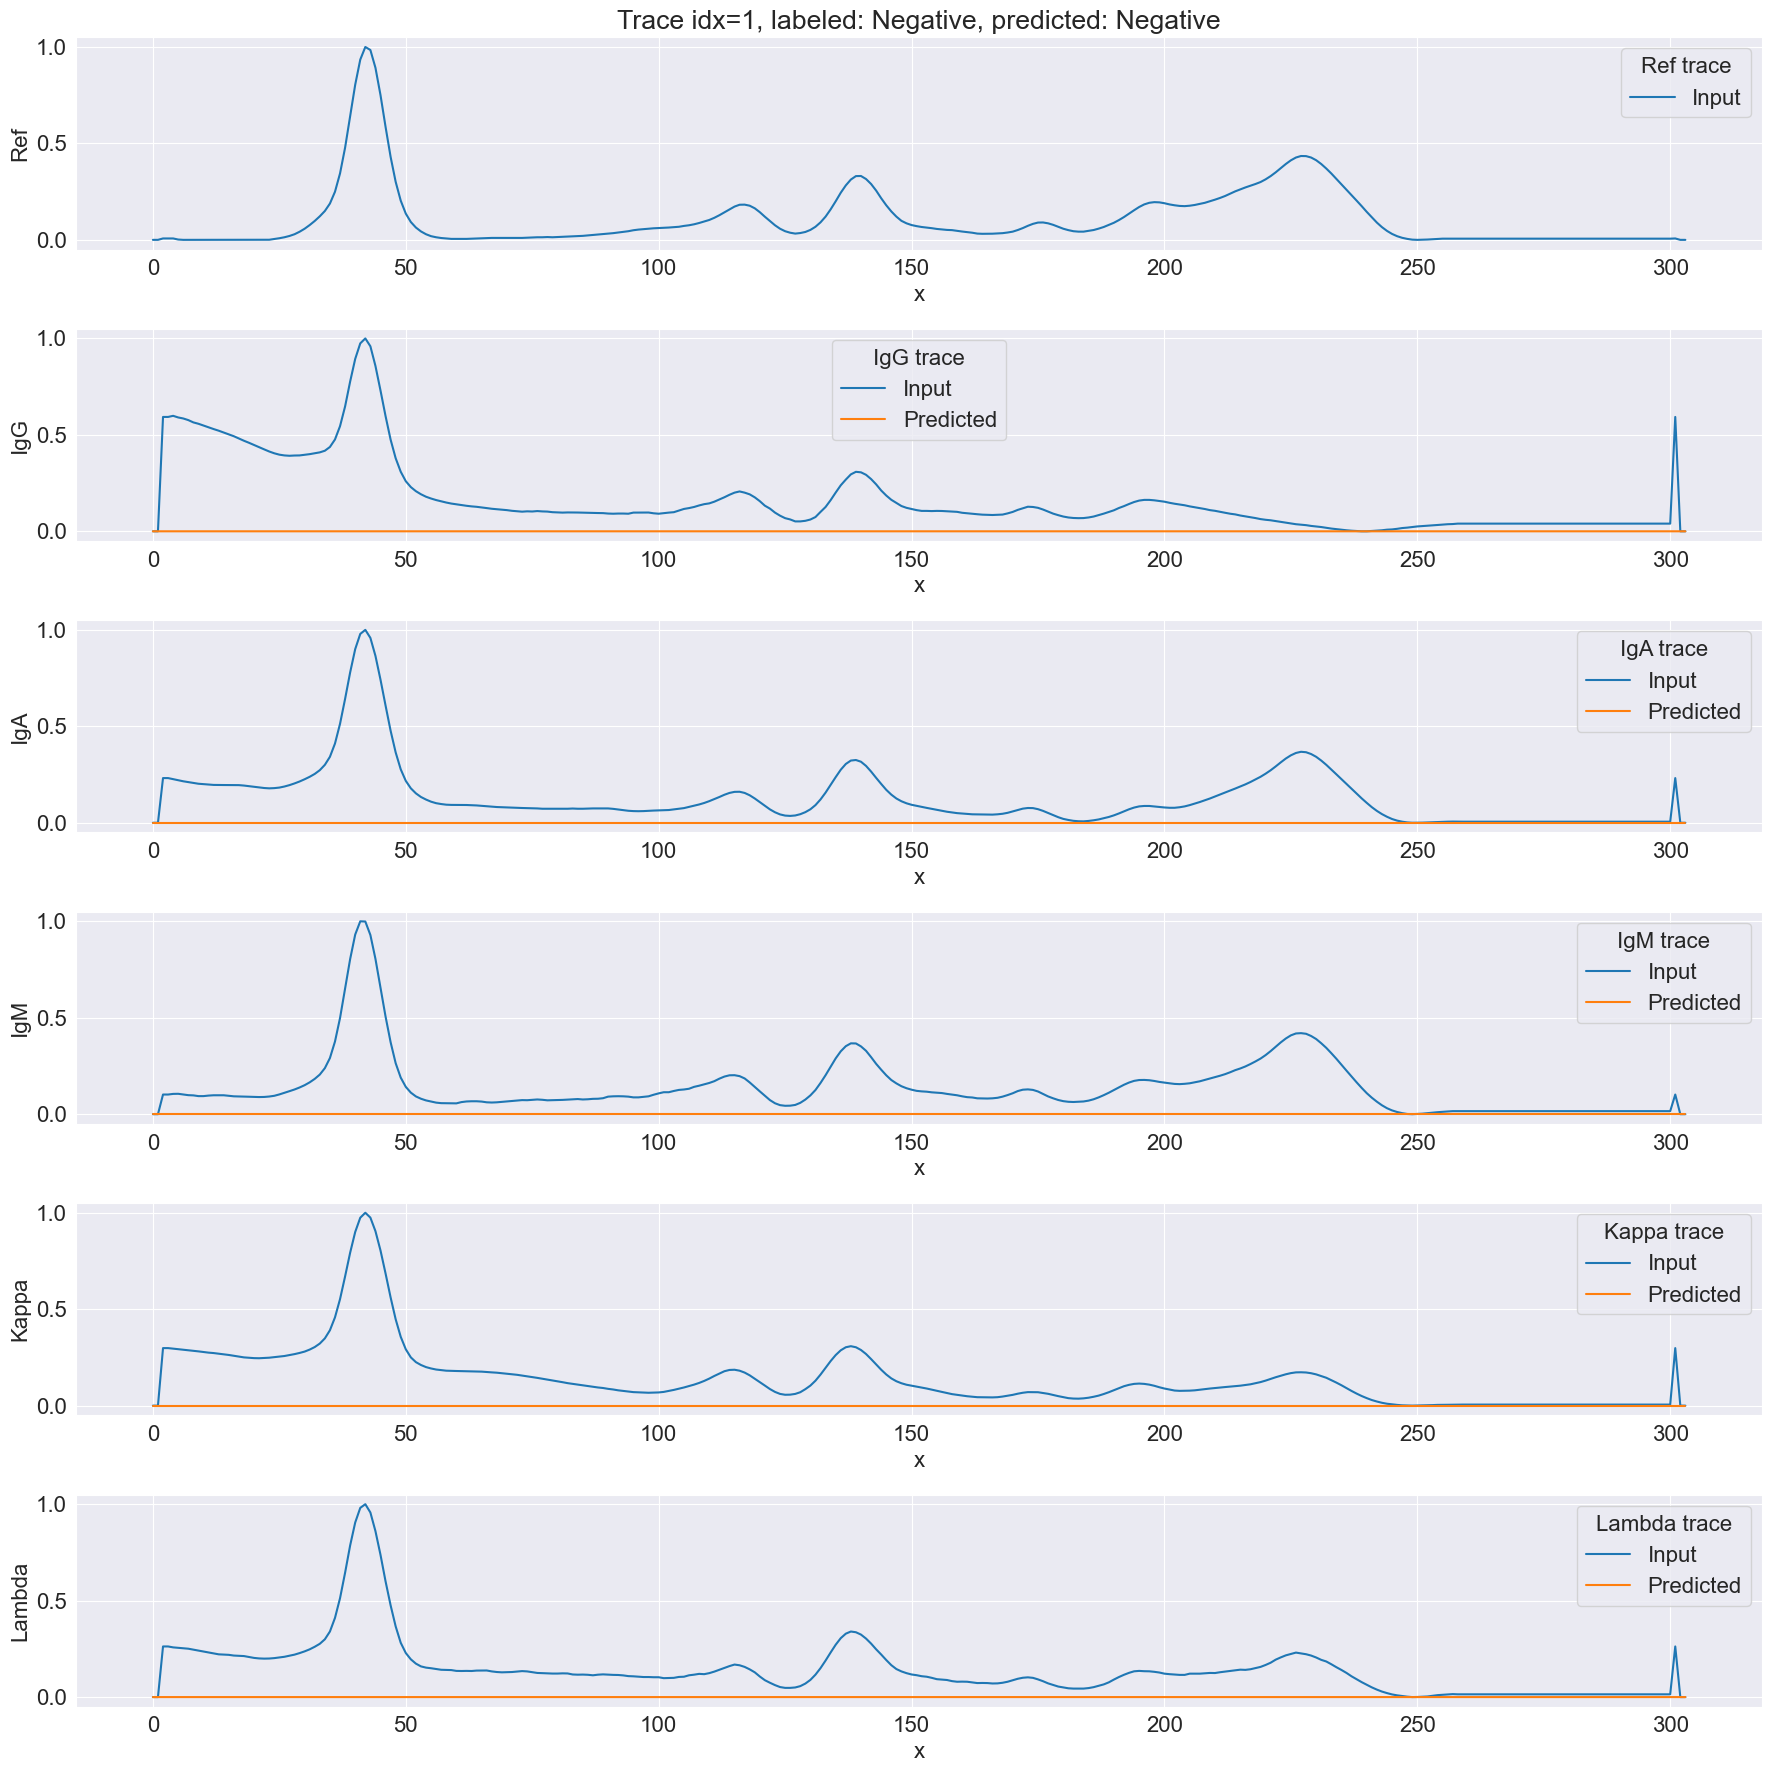

In [24]:
plot_it_short(1)

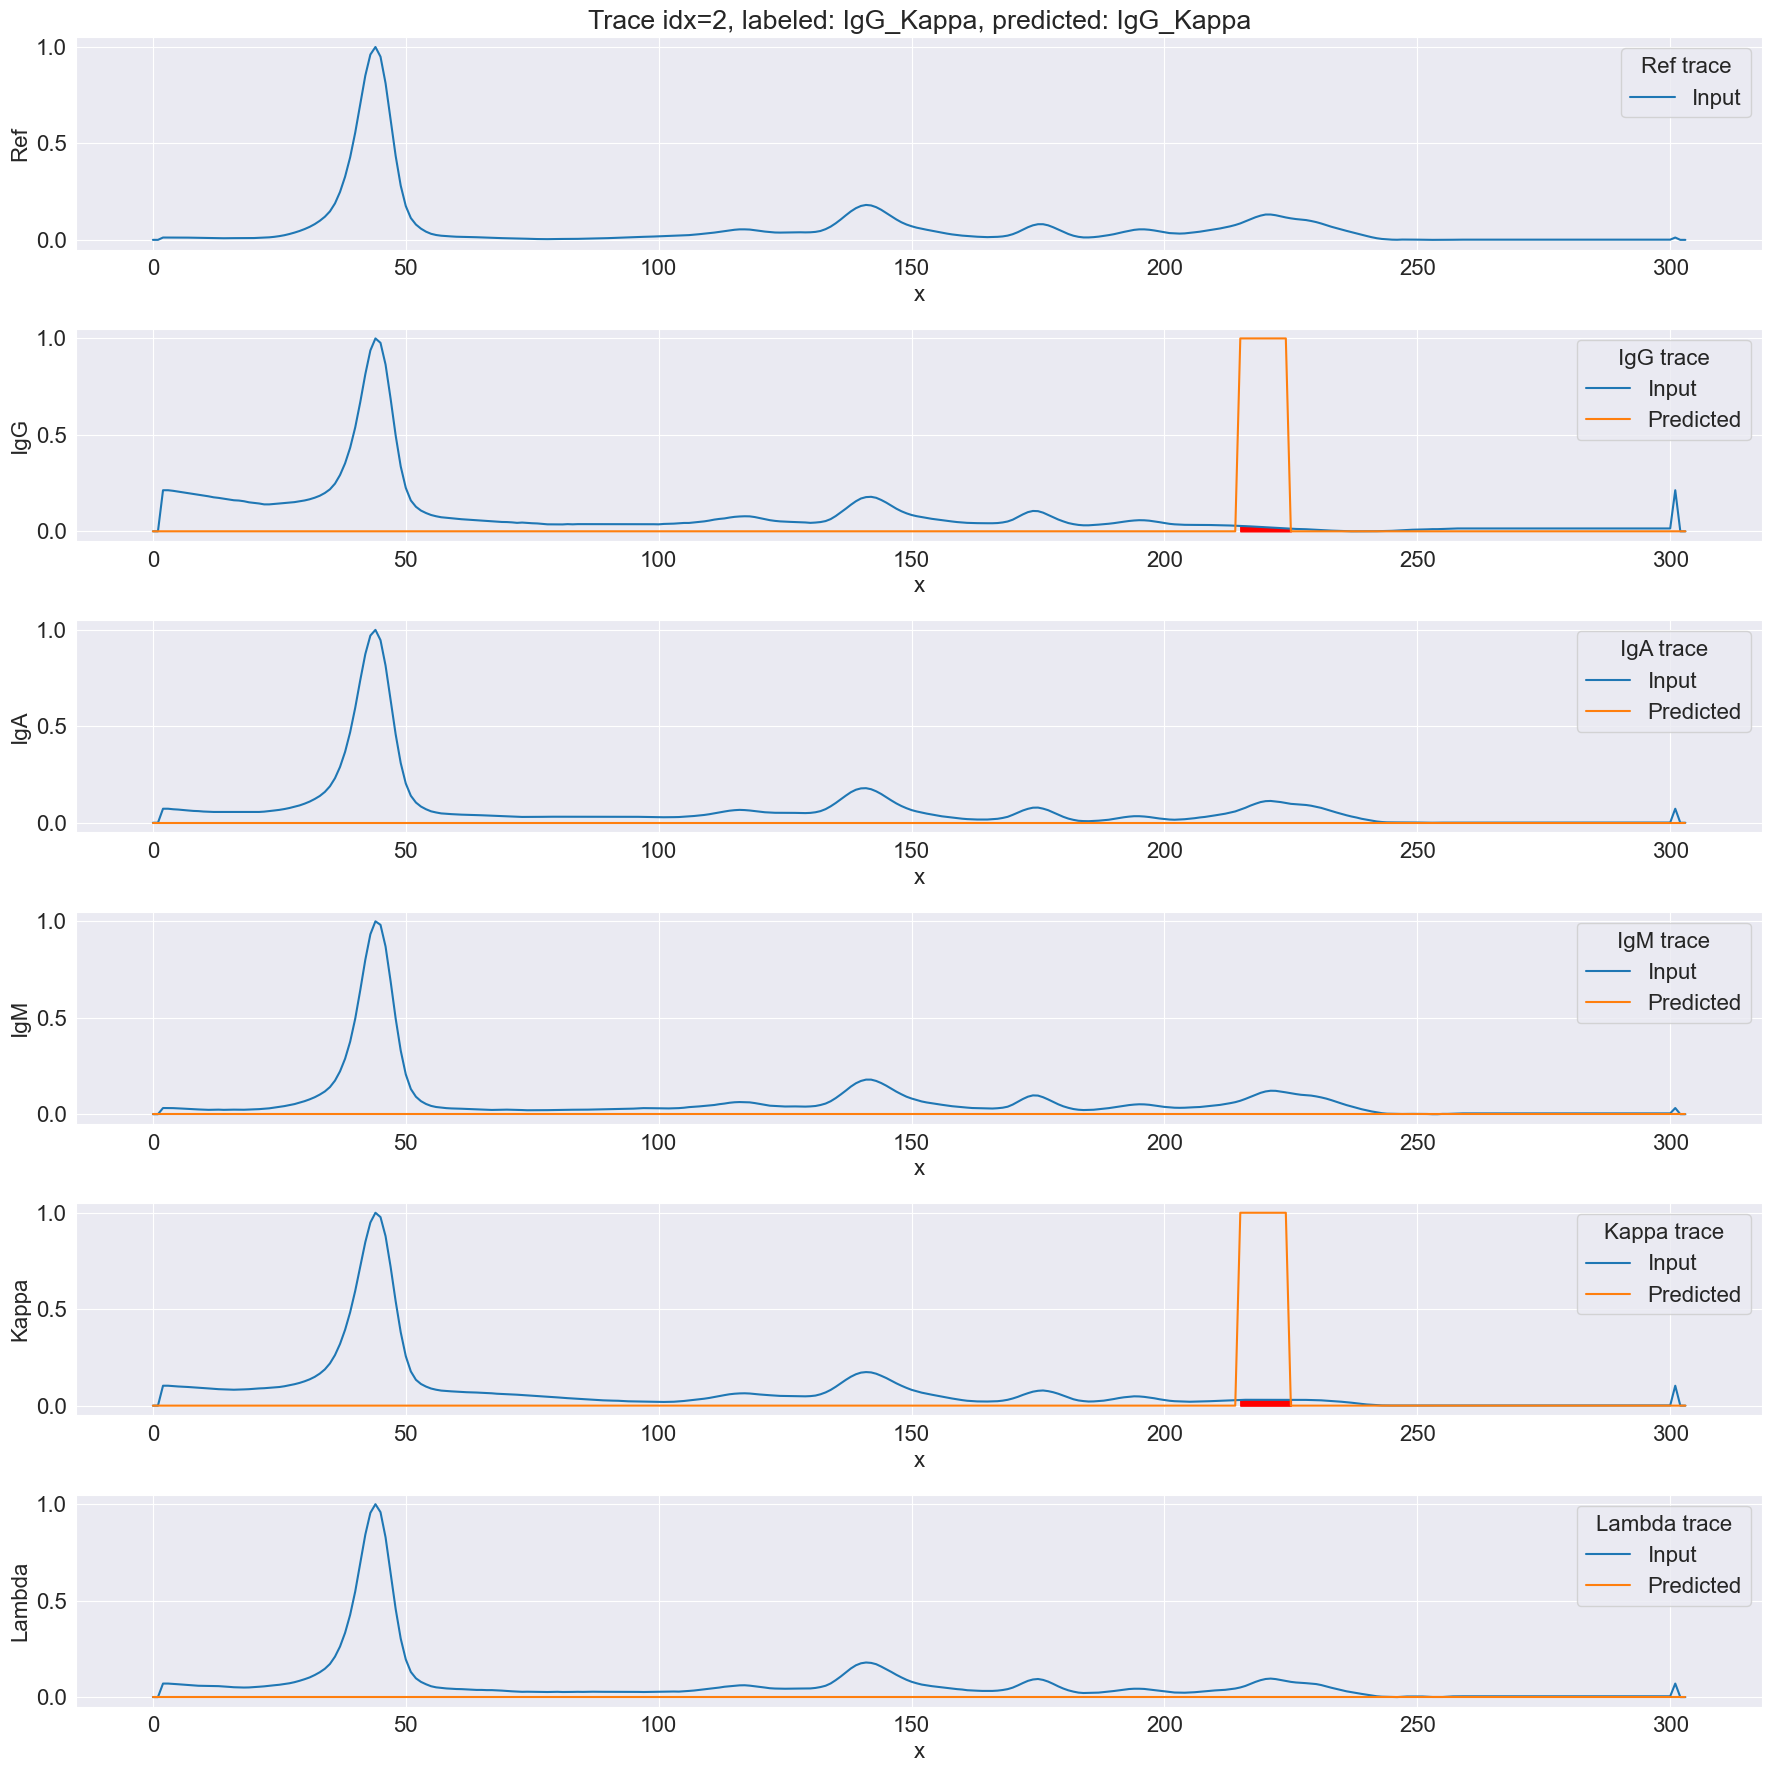

In [25]:
plot_it_short(2)

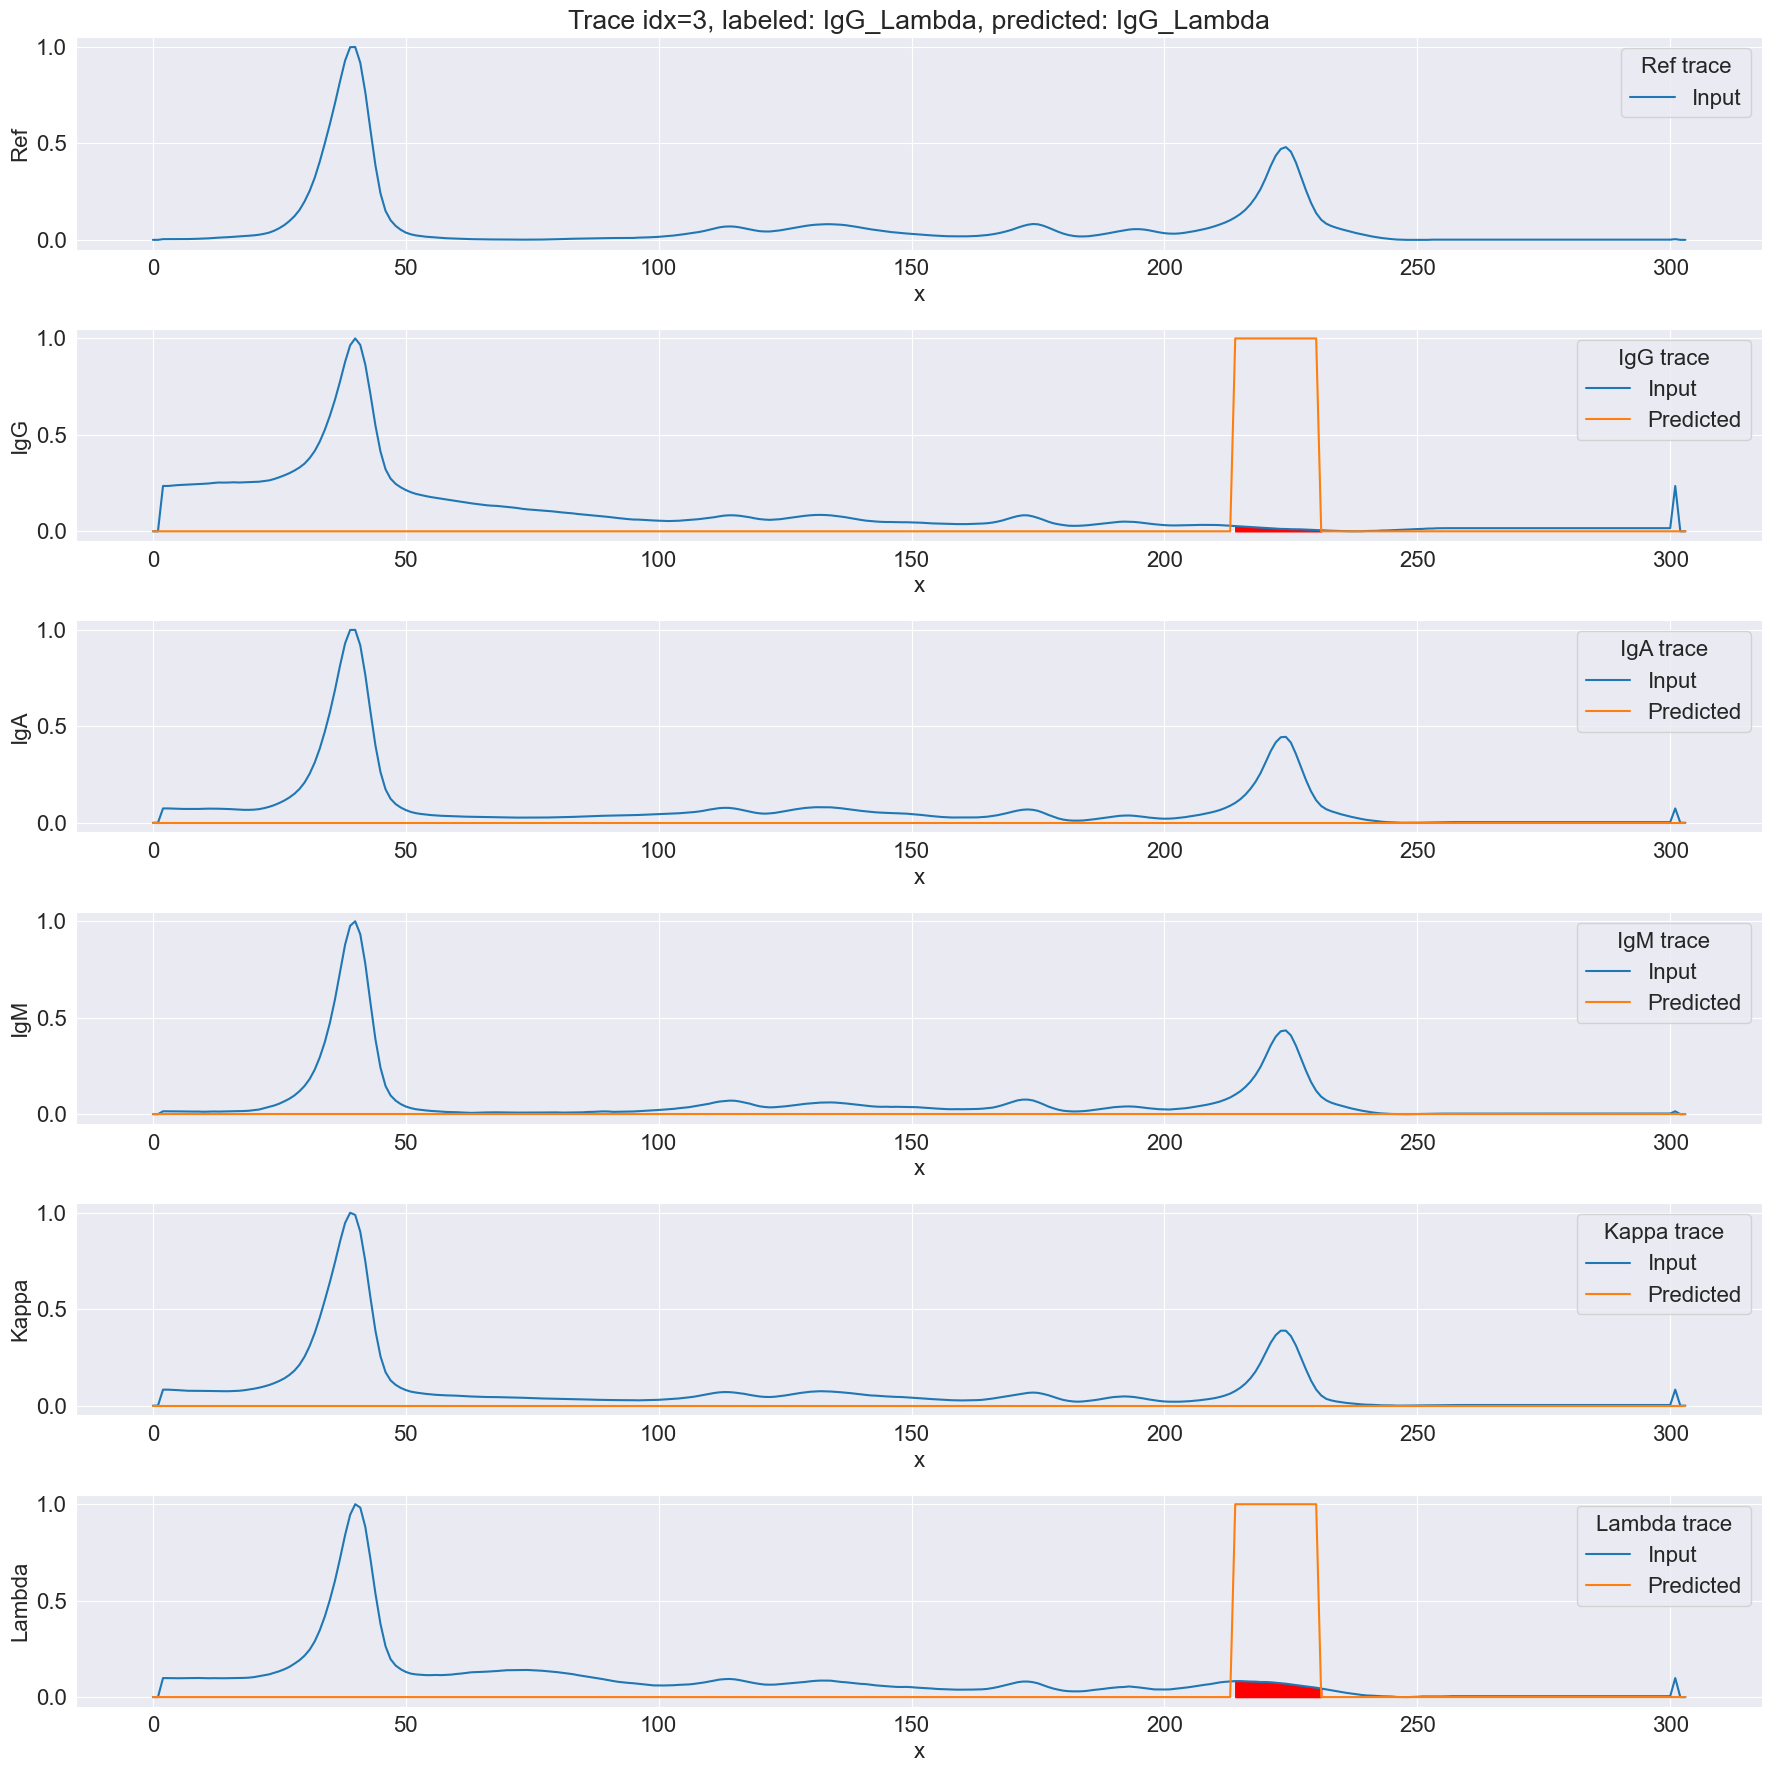

In [26]:
plot_it_short(3)

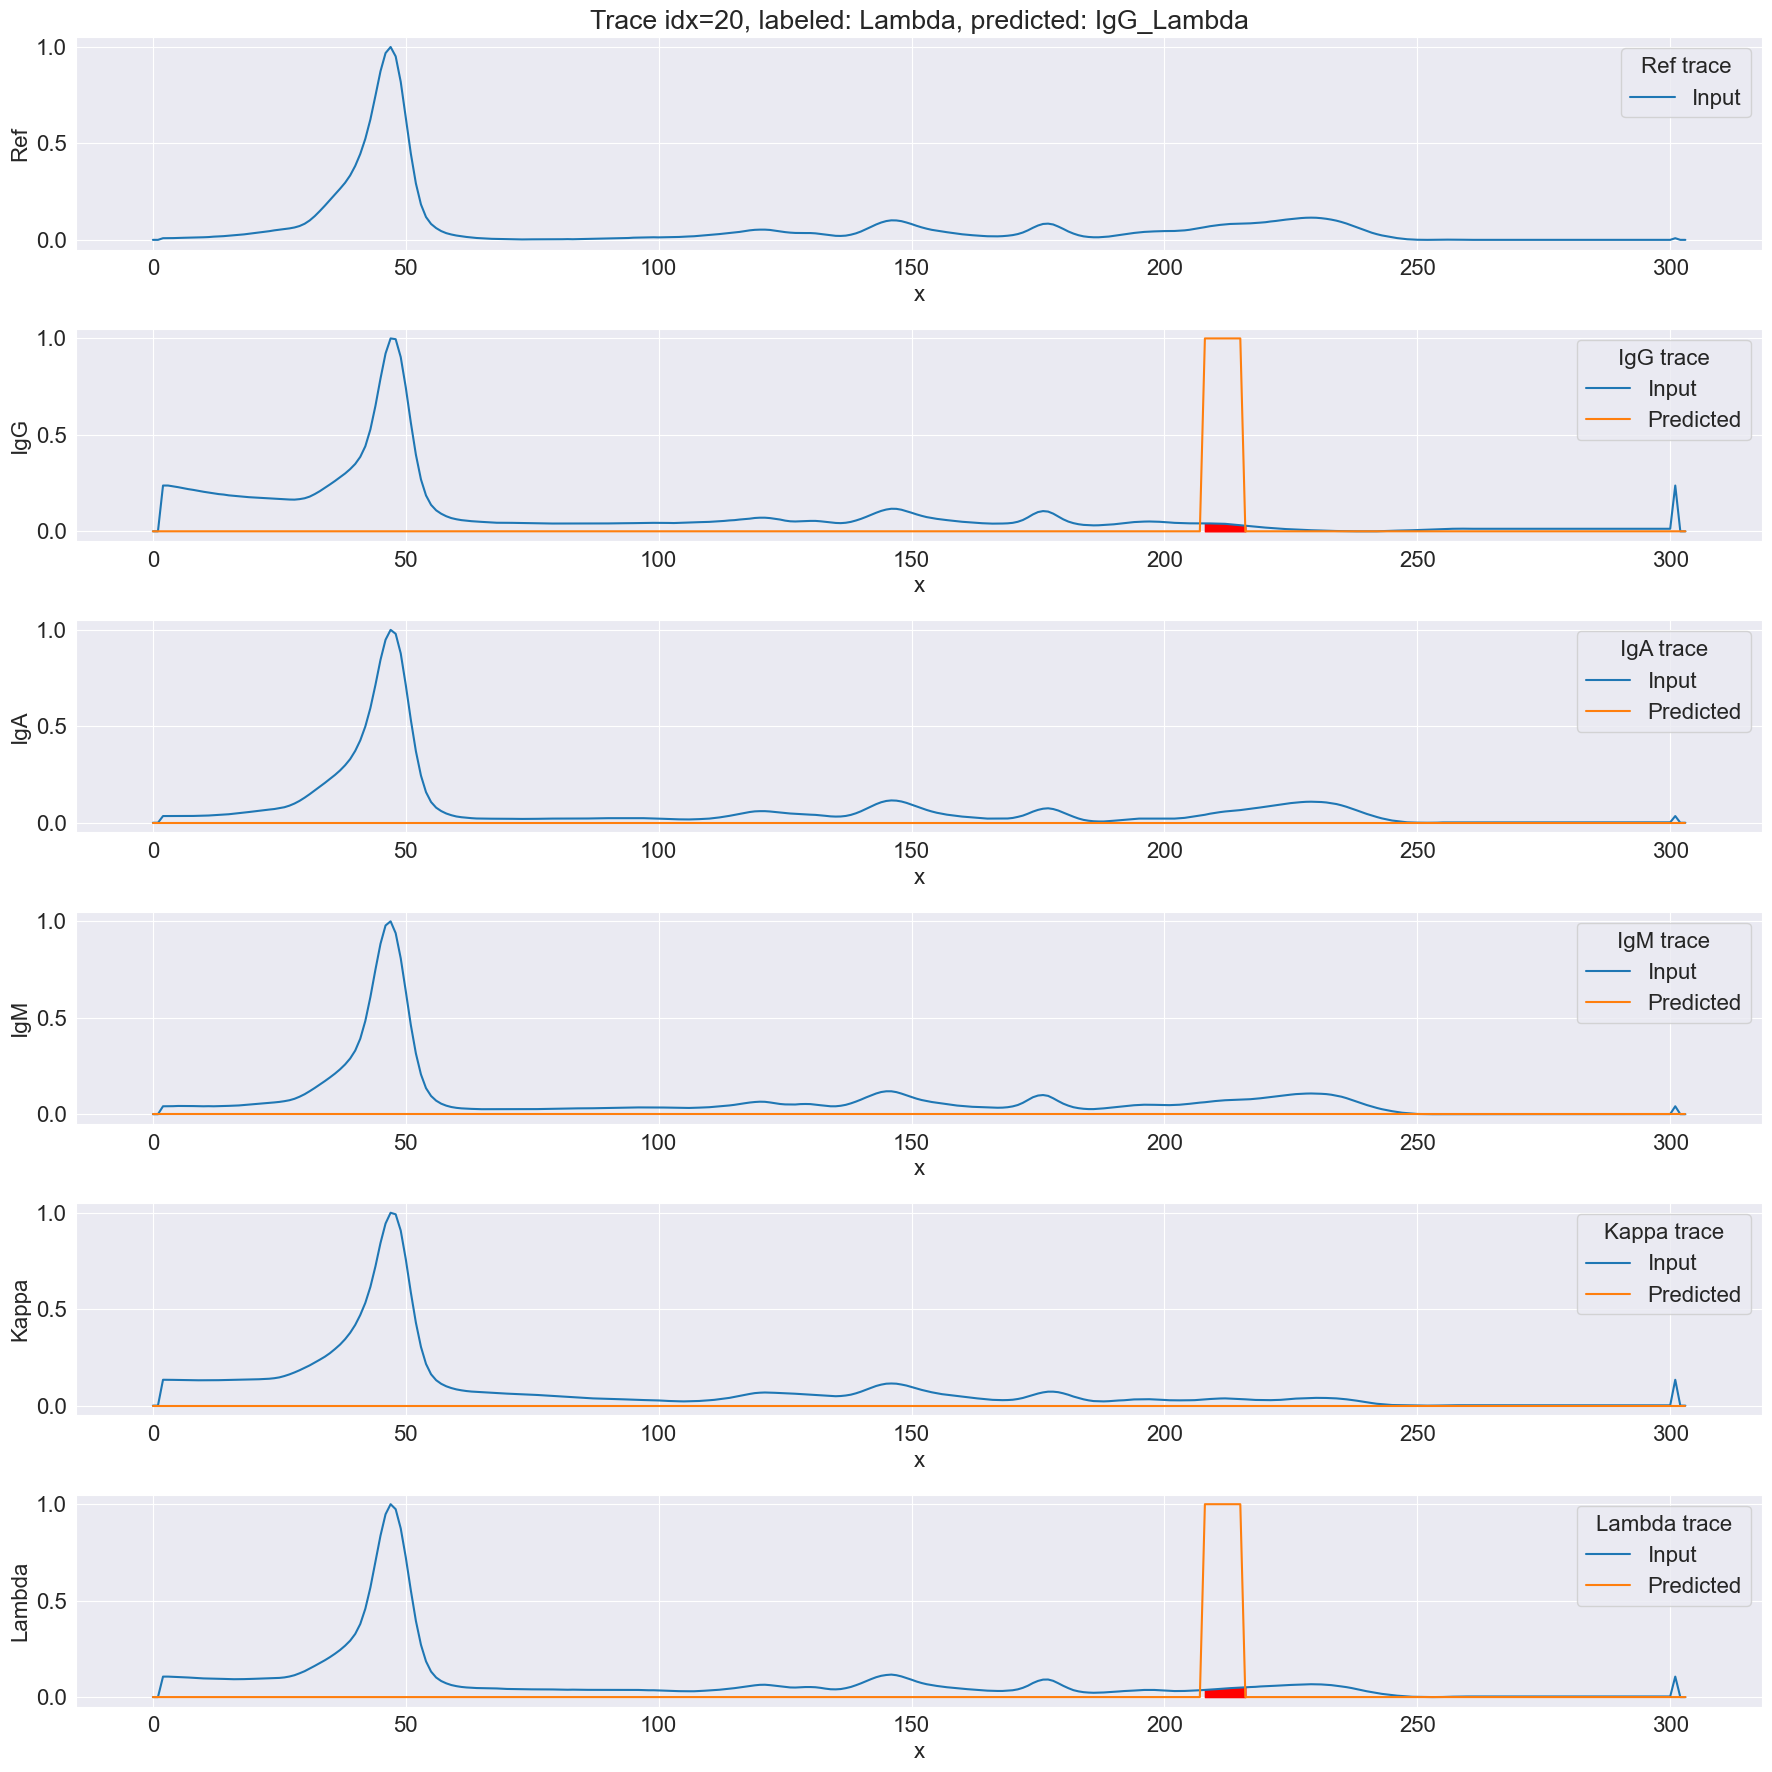

In [27]:
plot_it_short(20)

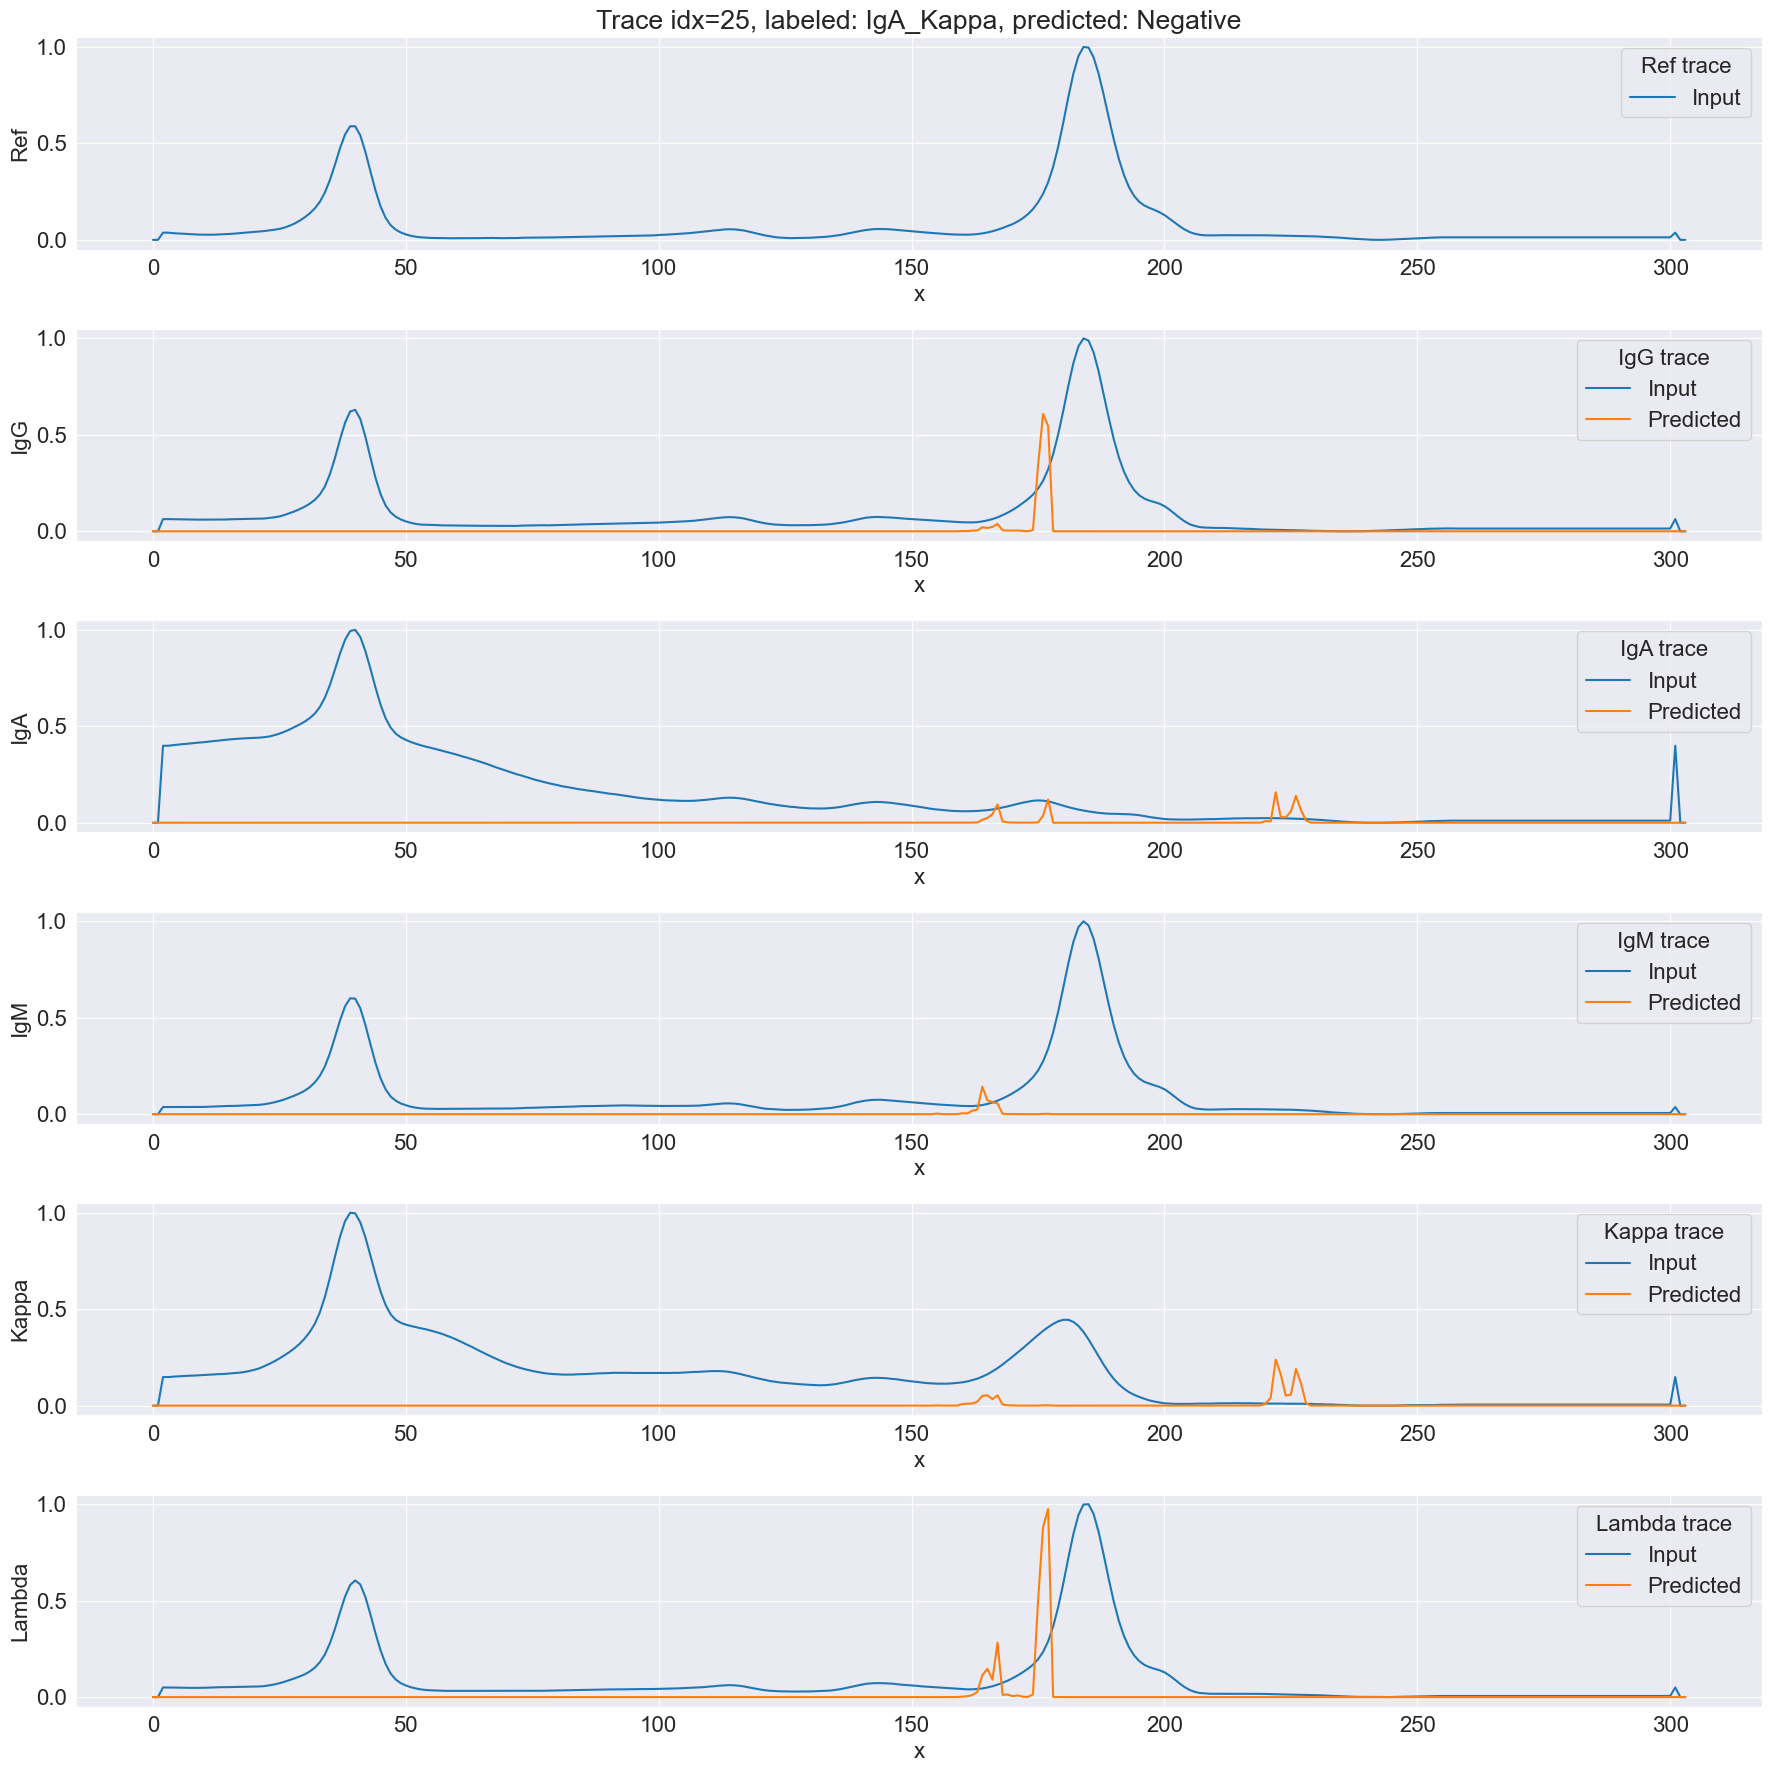

In [43]:
plot_it_short(25)